In [2]:
from graph_tool.all import *
from graph_tool import generation as gt
import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib


# Sample random graph with power-law degree sequence


n = 2000
max_degree = 100

def deg_sampler():
    accept = False
    while not accept:
        k = randint(2, max_degree)
        accept = random() < k**(-2.5)
    return k
    
    
g = gt.random_graph(n, deg_sampler, directed = False)
pos = sfdp_layout(g)

deg_distr = g.get_total_degrees(g.get_vertices())
avg_deg = np.mean(deg_distr)
avg_deg_sqr = np.mean(deg_distr**2)
print((avg_deg, avg_deg_sqr))
print(avg_deg/avg_deg_sqr) # Epidemic threshold for SIS on this network




(4.275, 52.554)
0.08134490238611713


0.3333333333333333


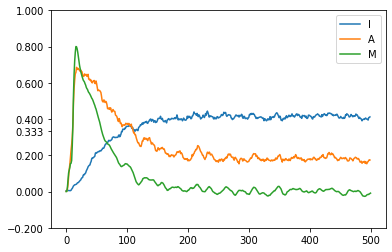

In [18]:
T = 500
b1 = 1/20 # infection rate
u1 = 1/10 # recovery rate
b2 = 0 # behavior change rate
u2 = 1/5 # rate of reverting behavioral change
u3 = -np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks
a1 = 0.3 # a1*b1 is the effective infection probability for adopters of protections
a2 = 0.5 # a2 * M[t] as the media effect on awareness spreading
r1 = 0 # weight of the current infection prevalence for media growth
r2 = 0.1 # weight of the d-day change in infection prevalence for media growth
d = 7 # time span for the change in infection prevalence revelant to media growth

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted

# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = 5): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T+1)


for t in range(T):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else a1)*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-len(ns)*b_eff):
                I_state[v] = I
                B_state[v] = A
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = S
        
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < max(1 - math.exp(-len(ns)*b2), a2*m[t]):
                B_state[v] = A
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
    
    i[t] = GraphView(g, vfilt=lambda v: I_state[v] == I).num_vertices()/g.num_vertices()
    growth_term = min((i[t]-i[max(0, t - d)])/i[max(0, t - d)], 3) #
    m[t+1] = m[t] + (1-m[t])*(r1*i[t] + r2*growth_term) - u3*m[t]
    a[t] = GraphView(g, vfilt=lambda v: B_state[v] == A).num_vertices()/g.num_vertices()


plt.plot(range(T), i)
plt.plot(range(T), a)
plt.plot(range(T+1), m)
plt.legend(["I", "A", "M"])


simple_limit = b1/(b1 + u1) # SIS endemic state equilibrium for parameters b1, u1, without protections or network topology
print(simple_limit)
plt.yticks(list(plt.yticks()[0]) + [simple_limit])
plt.show()




0.5


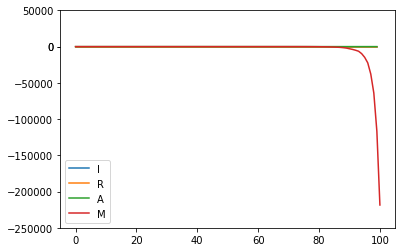

In [15]:
T = 100
b1 = 1/10 # infection rate
u1 = 1/10 # recovery rate
b2 = 0 # behavior change rate
u2 = 1/5 # rate of reverting behavioral change
u3 = -np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
a2 = 0.5 # a2 * M[t] as the media effect on awareness spreading
r1 = 0.5 # weight of the current infection prevalence for media growth
r2 = 0.98 # weight of the d-day change in infection prevalence for media growth
d = 7 # time span for the change in infection prevalence revelant to media growth

S = [1, 1, 1, 1]           # White color
I = [1, 0, 0, 1]           # Black color
R = [0, 0, 0, 1]  
N = 0 # protections not adopted
A = 1 # protections adopted

# Initialize all vertices to the S state
I_state = g.new_vertex_property("vector<double>")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = 5): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
r = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T+1)


for t in range(T):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else a1)*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-len(ns)*b_eff):
                I_state[v] = I
                B_state[v] = A
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = R
        
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < max(1 - math.exp(-len(ns)*b2), a2*m[t]):
                B_state[v] = A
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
    
    i[t] = GraphView(g, vfilt=lambda v: I_state[v] == I).num_vertices()/g.num_vertices()
    r[t] = GraphView(g, vfilt=lambda v: I_state[v] == R).num_vertices()/g.num_vertices()
    m[t+1] = m[t] + (1-m[t])*(r1*i[t] + r2*(i[t]-i[max(0, t - d)])/i[t]) - u3*m[t]
    a[t] = GraphView(g, vfilt=lambda v: B_state[v] == A).num_vertices()/g.num_vertices()


plt.plot(range(T), i)
plt.plot(range(T), r)
plt.plot(range(T), a)
plt.plot(range(T+1), m)
plt.legend(["I", "R", "A", "M"])


simple_limit = b1/(b1 + u1)
print(simple_limit)
plt.yticks(list(plt.yticks()[0]) + [simple_limit])
plt.show()




# Parameter choices

$\mu = -\frac{ln(0.5)}{14} \approx 0.05$, which is such that $e^{(-14\mu)} = \frac{1}{2}$, i.e. a halflife of 14 days 
  
$r_1 \geq g(M, I) = \frac{\mu M}{(1-M)I}$, with $r_2 = 0$, implies that $M$ increases even for $I$ staying at a fixed value.   
We can then choose $r_1$ based on the value of $M$ that we'd like to be able to roughly "sustain itself", without any spike in cases. For example with $g(0.5, 0.1) = 0.5$, meaning that $r_1 = 0.5$ means that a media value of $0.5$ can sustain itself when the infective prevalence is stable at $0.1$  

$r_2 \geq \frac{\mu M I_t}{(1-M)(I_t - I_{t-d})}$

\textbf{dfsjdhfkjsd}


\begin{itemize}
    \item \href{https://drive.google.com/file/d/1QolEdZoNxfvySx53LBQEF407fdpRWEx0/view?usp=sharing}{Link to google drive file containing notes on AME}
    \item Started modelling and simulating. For now, mass media effect is a continuous $[0,1]$ variable $M$, obeying this differential equation: 
    \[\frac{dM}{dt} = (1 - M(t)p_i(t) - \mu_MM(t)\]
    Where $p_i$ is the infection prevalence over the network. The idea is that media awareness can only grow when there is substantial infection, but there's saturation (i.e. carrying capacity 1), and there's decay. Not sure growth rate proportional to $p_i$ makes sense.
\end{itemize}